# Data Augmentation using VAE for Fraud Detection
This project aims to create a fraud detection model on an unbalanced dataset. Positive fraud instances make up just 0.17% of the dataset, posing the primary challenge for this project. Common methods for addressing unbalanced datasets include over- or under-sampling, either training a model on a smaller portion of the majority class or sampling the minority class with replacement to produce an even dataset. More modern deep learning methods, however, provide new options for addressing this problem. Variational Autoencoders are a neural network which can generate synthetic datapoints resembling those of the minority class, providing a more even distribution. They consist of an encoder, which represents the input data in a lower dimension latent space, and a decoder, which reconstructs the original data. Noise is added to the latent space to add variance to the generated data. This dataset is from kaggle.com and is not part of any competition. 

## Project Roadmap
In this project I will perform basic EDA on the chosen dataset, build a Variational Autoencoder, and compare the efficacy and performance of several variations of a basic Random Forest Classifier. Models will be constructed using over sampling methods, such as bagging and weighting of class values, on both the unbalanced dataset and an augmented dataset using synthetic data from a VAE. Typical metrics for measuring classification performance, such as accuracy, fall short in unbalanced datasets since a model that classifies all instances as the majority class would likely score very well. Instead, a host of metrics will be used in model evaluation to explore the performace of model iterations. The goal of this project is to produce a model that can accurately predict model classes in an unbalanced dataset with the help of deep learning techniques.

### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

### Loading Data

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Data Imbalance Visualized
The graph below puts the data imbalance into visual perspective. Any effective classification model of this data will need to account for this difference. Luckily modern deep learning solutions provide tools to help account for this and imporive model performance.

In [5]:
class_counts = df['Class'].value_counts()

Text(0.5, 1.0, 'Counts of Each Classification')

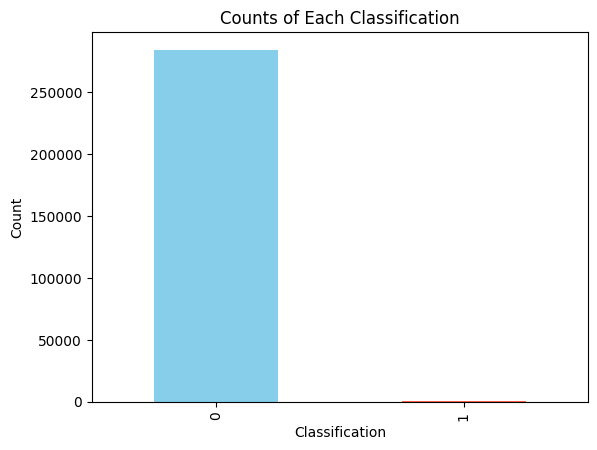

In [6]:
ax = class_counts.plot(kind='bar', color=['skyblue', 'tomato'])
ax.set_xlabel('Classification')
ax.set_ylabel('Count')
ax.set_title('Counts of Each Classification')

In [7]:
class_counts

Class
0    284315
1       492
Name: count, dtype: int64

In [8]:
print(f"Percent of Positive Classifications: {100 * class_counts[1]/len(df)}%")

Percent of Positive Classifications: 0.1727485630620034%


### Data Cleaning and Preprocessing
This dataset is already relatively clean and ready for use. Inspection shows that no NaN nor non-numeric values are present in the dataset.

In [9]:
df.isna().value_counts()

Time   V1     V2     V3     V4     V5     V6     V7     V8     V9     V10    V11    V12    V13    V14    V15    V16    V17    V18    V19    V20    V21    V22    V23    V24    V25    V26    V27    V28    Amount  Class
False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False   False    284807
Name: count, dtype: int64

In [10]:
non_numeric = {}

for column in df.columns:
    non_numeric_mask = pd.to_numeric(df[column], errors='coerce').isna()

    original_nans = df[column].isna()
    non_numeric_mask = non_numeric_mask & ~original_nans

    count = non_numeric_mask.sum()
    non_numeric[column] = count

for col, count in non_numeric.items():
    print(f"Column '{col}': {count} non-numeric values")

Column 'Time': 0 non-numeric values
Column 'V1': 0 non-numeric values
Column 'V2': 0 non-numeric values
Column 'V3': 0 non-numeric values
Column 'V4': 0 non-numeric values
Column 'V5': 0 non-numeric values
Column 'V6': 0 non-numeric values
Column 'V7': 0 non-numeric values
Column 'V8': 0 non-numeric values
Column 'V9': 0 non-numeric values
Column 'V10': 0 non-numeric values
Column 'V11': 0 non-numeric values
Column 'V12': 0 non-numeric values
Column 'V13': 0 non-numeric values
Column 'V14': 0 non-numeric values
Column 'V15': 0 non-numeric values
Column 'V16': 0 non-numeric values
Column 'V17': 0 non-numeric values
Column 'V18': 0 non-numeric values
Column 'V19': 0 non-numeric values
Column 'V20': 0 non-numeric values
Column 'V21': 0 non-numeric values
Column 'V22': 0 non-numeric values
Column 'V23': 0 non-numeric values
Column 'V24': 0 non-numeric values
Column 'V25': 0 non-numeric values
Column 'V26': 0 non-numeric values
Column 'V27': 0 non-numeric values
Column 'V28': 0 non-numeric 

In [11]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [12]:
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
len(cols)

29

### Data Distribution Visualization
Below, the distributions of each feature in the original dataset and a subset with just fraudulent transactions are visualized. While outliers are present, removal of rows containin data points outside each feature's IQR leaves just ~50% of the dataset remaining. Because of this, further outlier analysis was not deemed prudent.

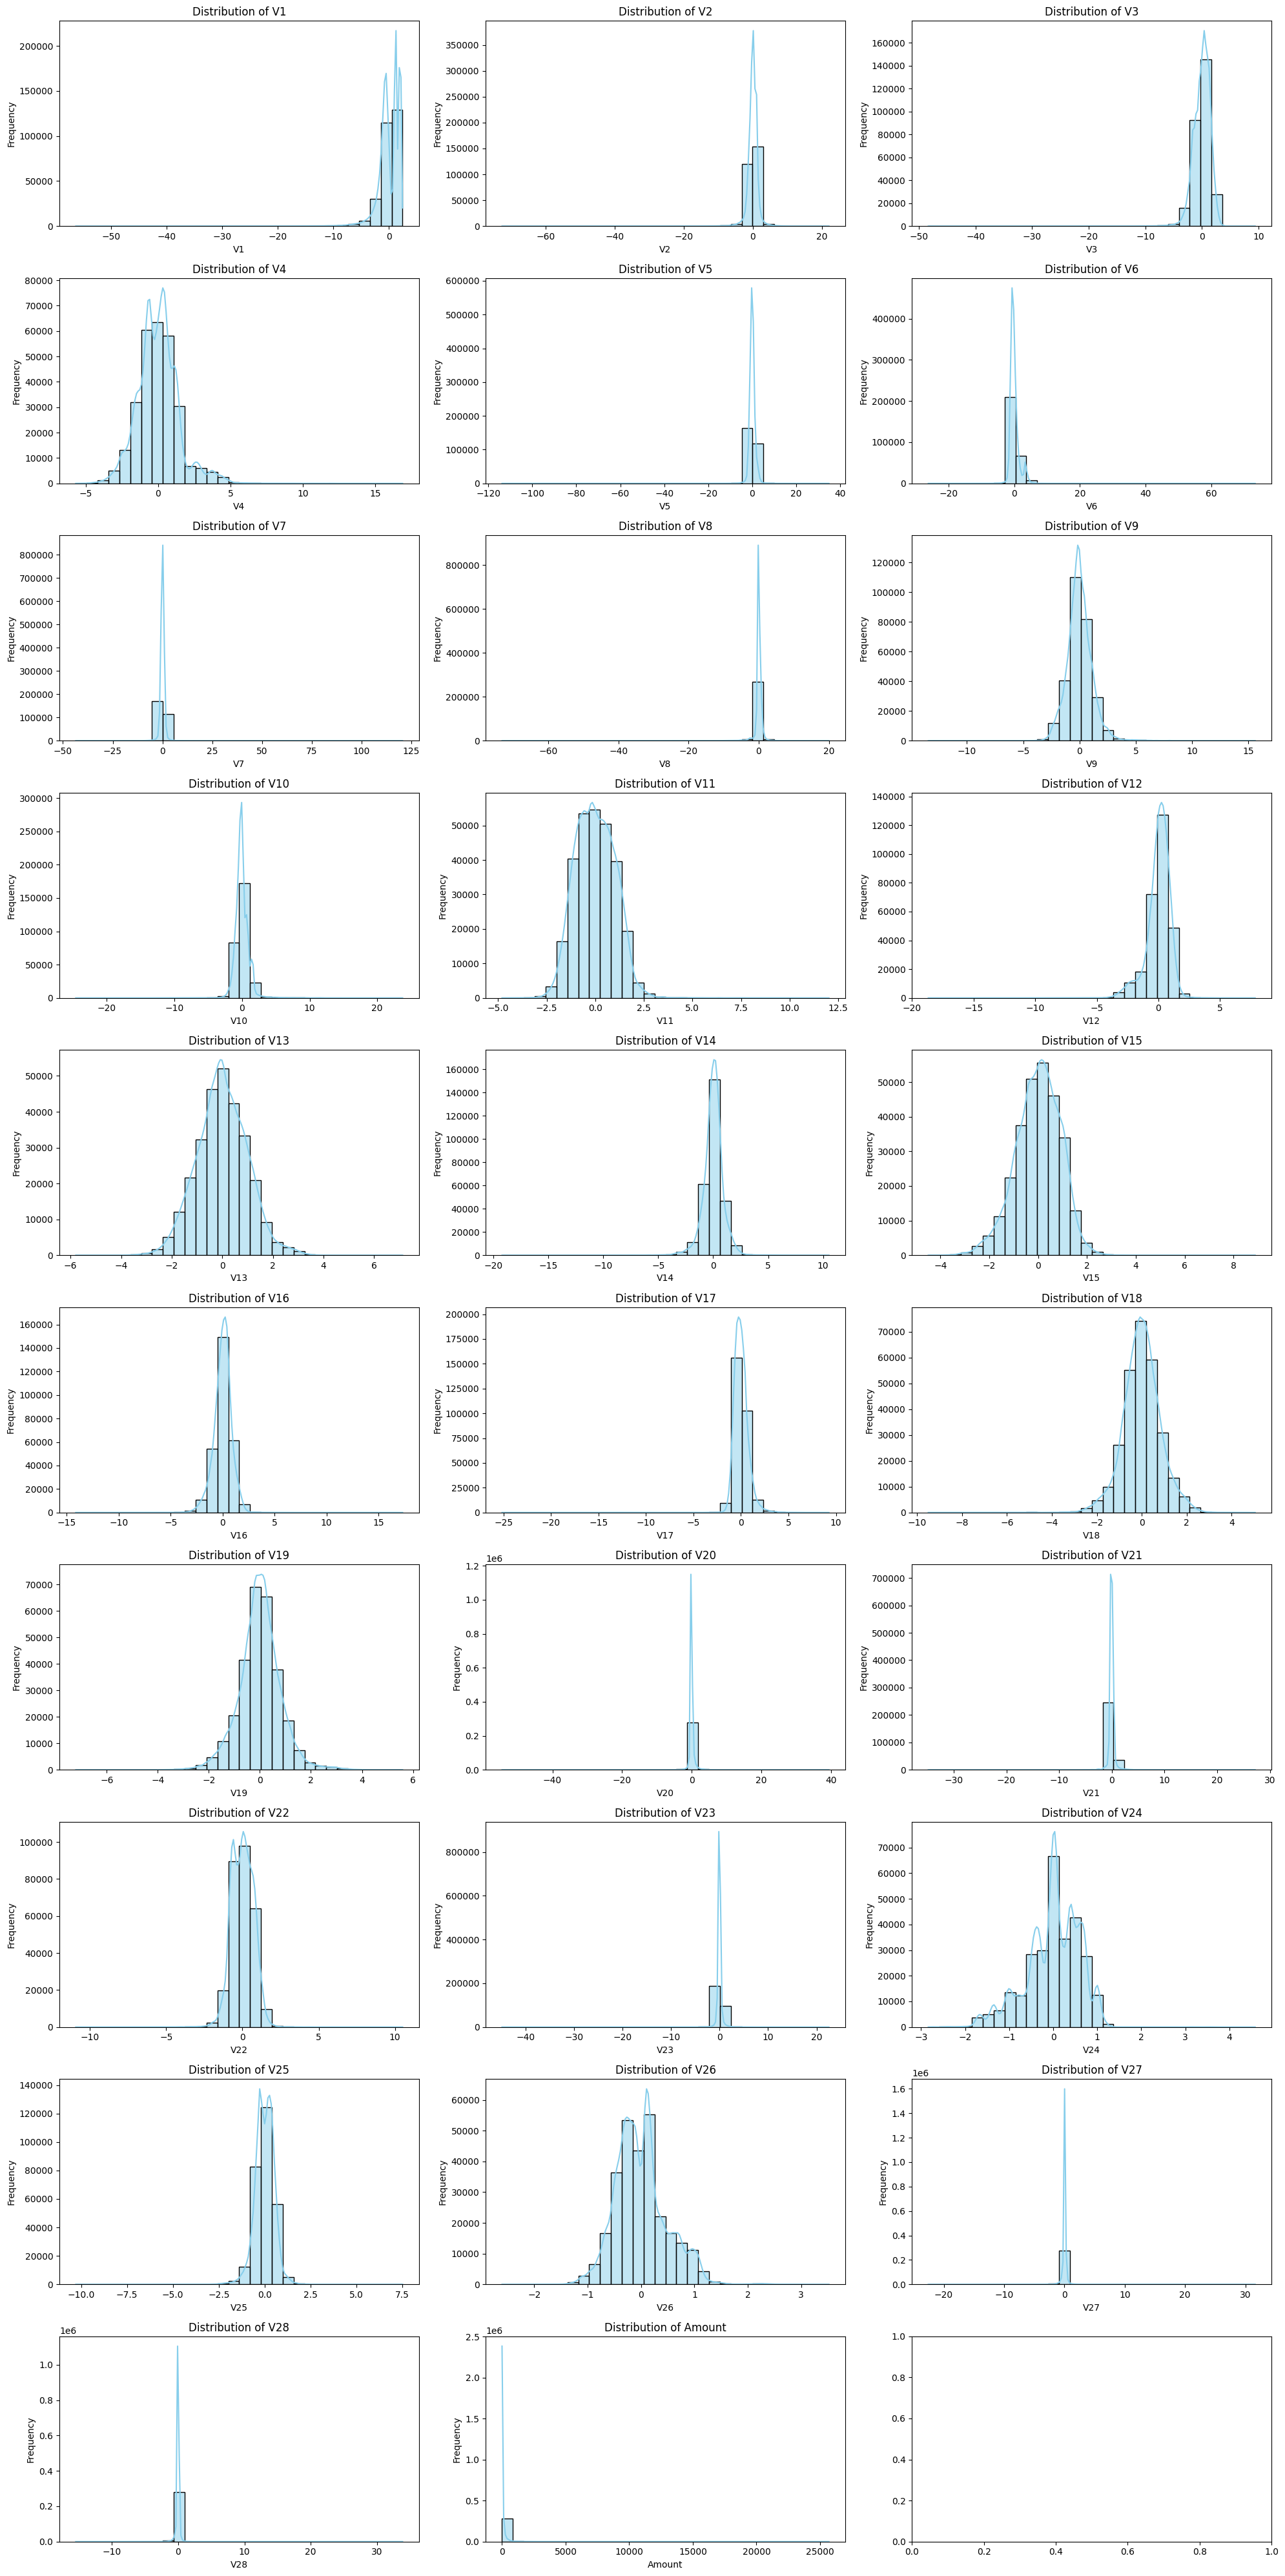

In [13]:
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(10, 3, figsize=(20, 40))
ax = ax.flatten()

for i, column in enumerate(cols):
    sns.histplot(df[column], kde=True, bins=30, color='skyblue', ax=ax[i])
    ax[i].set_title(f'Distribution of {column}')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

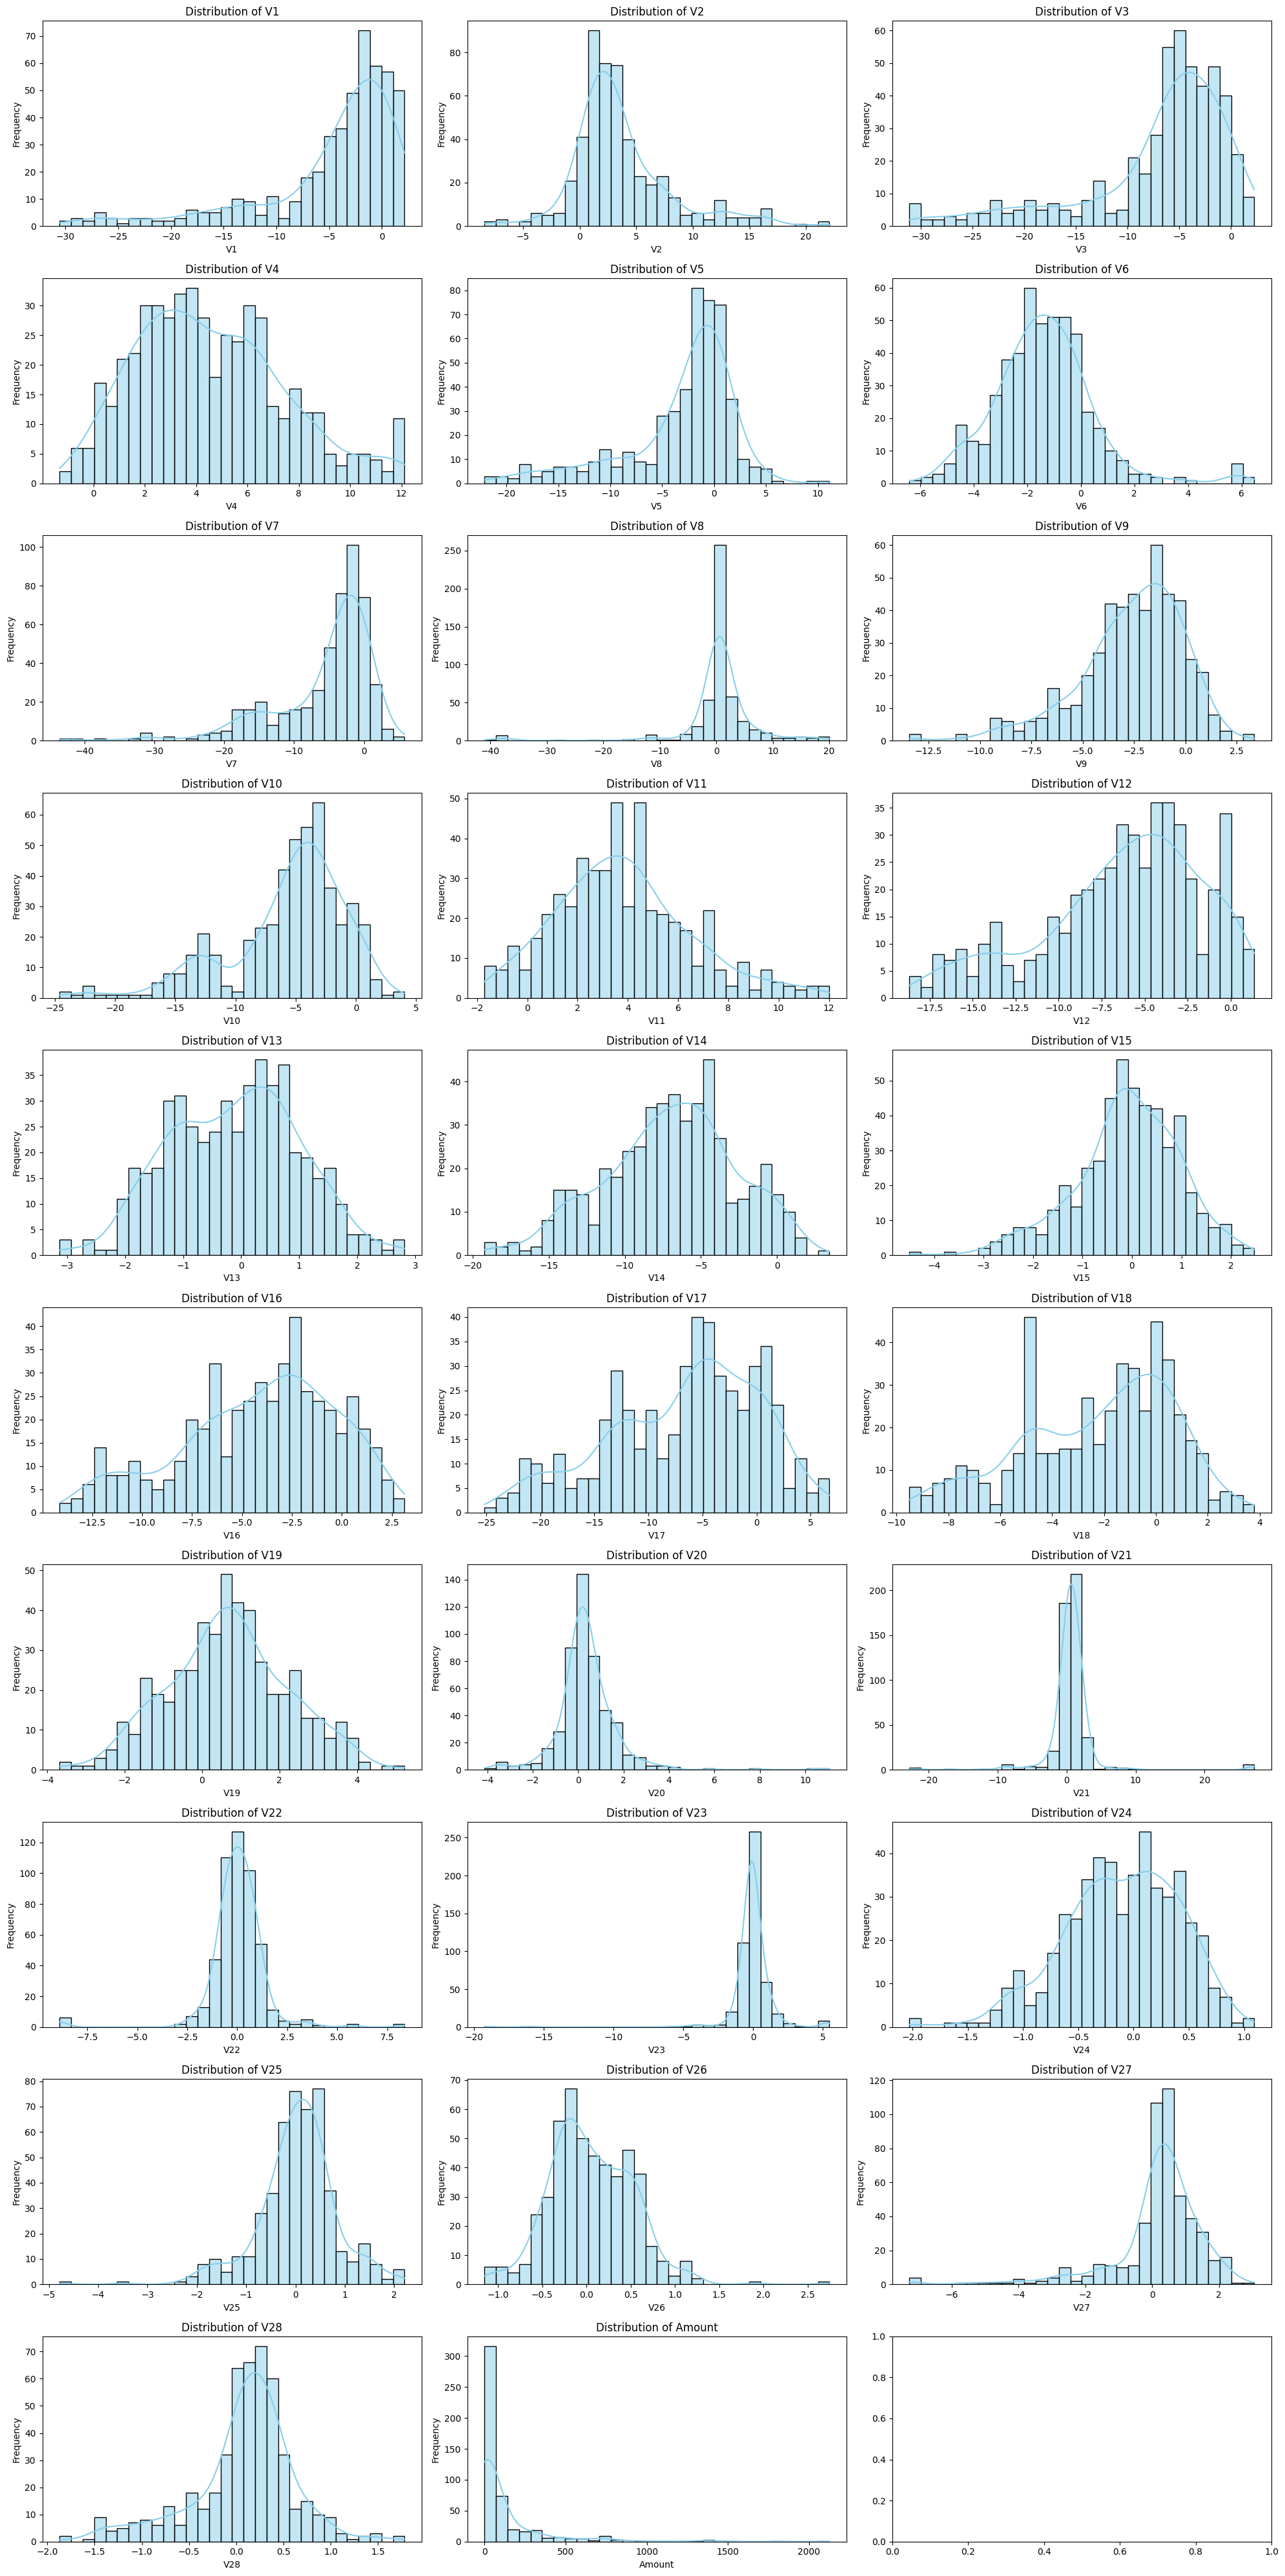

In [14]:
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
ax = ax.flatten()

for i, column in enumerate(cols):
    sns.histplot(df[column][df['Class']==1], kde=True, bins=30, color='skyblue', ax=ax[i])
    ax[i].set_title(f'Distribution of {column}')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

In [15]:
def remove_outliers(df):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_no_outliers = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]
    
    return df_no_outliers

df_temp = remove_outliers(df)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146319 entries, 0 to 284803
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    146319 non-null  float64
 1   V1      146319 non-null  float64
 2   V2      146319 non-null  float64
 3   V3      146319 non-null  float64
 4   V4      146319 non-null  float64
 5   V5      146319 non-null  float64
 6   V6      146319 non-null  float64
 7   V7      146319 non-null  float64
 8   V8      146319 non-null  float64
 9   V9      146319 non-null  float64
 10  V10     146319 non-null  float64
 11  V11     146319 non-null  float64
 12  V12     146319 non-null  float64
 13  V13     146319 non-null  float64
 14  V14     146319 non-null  float64
 15  V15     146319 non-null  float64
 16  V16     146319 non-null  float64
 17  V17     146319 non-null  float64
 18  V18     146319 non-null  float64
 19  V19     146319 non-null  float64
 20  V20     146319 non-null  float64
 21  V21     146319 

## VAE Data Synthesis and Model Creation

Below are several helper functions which build a Variational Autoencoder, prepare the data for modeling, generate synthetic samples, build several iterations of Random Forest Classifiers, and visualize the ensuing models and their performance. The VAE Algorithm works by:
* Encoding imput data to return latent space parameters (mean and log variance) and a sampled latent vector;
* Decoding the latent vector to reconstruct the input;
* Computing binary cross-entropy as the reconstruction loss;
* Combining losses and using gradient descent to update the model.

In [16]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.beta * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### VAE Architecture
This function creates a complete VAE architecture with configurable dimensions. It builds an encoder network that compresses input data to a latent space using fully-connected layers and implements the reparameterization trick for sampling, then constructs a symmetric decoder network that reconstructs the original input from latent vectors. Finally, it combines these components into a compiled VAE model with an Adam optimizer, ready for training.

In [17]:
def create_vae(input_dim, latent_dim=2, hidden_dims=[128, 64]):

    encoder_inputs = keras.Input(shape=(input_dim,))
    x = encoder_inputs
    
    for dim in hidden_dims:
        x = layers.Dense(dim, activation="relu")(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(sampling)([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = latent_inputs
    
    for dim in reversed(hidden_dims):
        x = layers.Dense(dim, activation="relu")(x)
    
    decoder_outputs = layers.Dense(input_dim, activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    
    return vae

### Data Preparation

Here, the data is split into training and testing sets, scaled, and subset by class. Standardization of the data is necessary in training encoders, though the data will need to be inversely scaled at a later point.

In [18]:
def prepare_data(df, target_col):

    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1885)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    minority_indices = y_train == 1
    X_minority = X_train_scaled[minority_indices]
    
    return X_train_scaled, X_test_scaled, y_train, y_test, X_minority, scaler

### Generating Samples

The helper function below utilizes the above functions to create the synthetic samples used in model training.

In [19]:
def generate_synthetic_samples(vae, n_samples, seed=1885):

    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    z_sample = tf.random.normal((n_samples, vae.encoder.output_shape[0][1]))
    
    generated_samples = vae.decoder.predict(z_sample)
    
    return generated_samples

### PCA Visualization

Though this dataset itself is the result of a PCA transformation, further Principal Component Analysis is performed in order to visualize the real and synthetic data in a physical space. These results lack interpretability, but do help show the relative location of majority class, minority class, and synthetic data.

In [20]:
def visualize_data(X_real, X_synthetic, y_real=None, y_synthetic=None, method='PCA'):

    if method == 'PCA':

        pca = PCA(n_components=2)
        
        if y_real is not None and y_synthetic is not None:

            X_combined = np.vstack([X_real, X_synthetic])
            X_pca = pca.fit_transform(X_combined)
            
            X_real_pca = X_pca[:len(X_real)]
            X_synthetic_pca = X_pca[len(X_real):]
            
            plt.figure(figsize=(10, 8))
            
            plt.scatter(X_real_pca[y_real==0, 0], X_real_pca[y_real==0, 1], 
                        label='Real - Majority', alpha=0.5, s=10, color='blue')
            plt.scatter(X_real_pca[y_real==1, 0], X_real_pca[y_real==1, 1], 
                        label='Real - Minority', alpha=0.7, s=30, color='green')
            
            plt.scatter(X_synthetic_pca[:, 0], X_synthetic_pca[:, 1], 
                        label='Synthetic - Minority', alpha=0.7, s=20, color='red')
            
        else:
            X_real_pca = pca.fit_transform(X_real)
            X_synthetic_pca = pca.transform(X_synthetic)
            
            plt.figure(figsize=(10, 8))
            plt.scatter(X_real_pca[:, 0], X_real_pca[:, 1], 
                        label='Real data', alpha=0.6, s=10, color='blue')
            plt.scatter(X_synthetic_pca[:, 0], X_synthetic_pca[:, 1], 
                        label='Synthetic data', alpha=0.7, s=20, color='red')
        
        plt.title('PCA Visualization of Real and Synthetic Data')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

### Precision / Recall Curves

The helper function below will be utilized after models are trained in order to compare their performance.

In [21]:
def plot_precision_recall_curves(models_dict, X_test, y_test):

    plt.figure(figsize=(10, 8))
    
    for model_name, model in models_dict.items():
        y_scores = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        ap_score = average_precision_score(y_test, y_scores)
        
        plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {ap_score:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

### Random Forest Classification Model Building

This function produces 6 separate Random Forest Classification models. They include models with / without bootstrapping, with / without class weights, and neither for both the original unbalanced dataset and the augmented dataset. Evaluation metrics will be printed for each model.

In [22]:
def compare_random_forests(X_train, y_train, X_test, y_test, X_synthetic=None):

    results = {}
    models = {}
    
    configs = [
        {
            'name': 'RF Default',
            'bootstrap': True,
            'class_weight': None
        },
        {
            'name': 'RF with Class Weights',
            'bootstrap': True,
            'class_weight': 'balanced'
        },
        {
            'name': 'RF without Bootstrap',
            'bootstrap': False,
            'class_weight': None
        }
    ]
    

    if X_synthetic is not None:
        y_synthetic = np.ones(X_synthetic.shape[0])
        
        X_train_augmented = np.vstack([X_train, X_synthetic])
        y_train_augmented = np.concatenate([y_train, y_synthetic])
        
        data_variants = [
            ('Original', X_train, y_train),
            ('Augmented', X_train_augmented, y_train_augmented)
        ]
    else:
        data_variants = [('Original', X_train, y_train)]
    
    for data_name, X, y in data_variants:
        for config in configs:
            model_name = f"{data_name} {config['name']}"
            
            # Create and train model
            model = RandomForestClassifier(
                n_estimators=100,
                random_state=1885,
                bootstrap=config['bootstrap'],
                class_weight=config['class_weight']
            )
            
            model.fit(X, y)
            
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            auc = roc_auc_score(y_test, y_pred_proba)
            avg_precision = average_precision_score(y_test, y_pred_proba)
            
            results[model_name] = {
                'auc': auc,
                'avg_precision': avg_precision,
                'config': config,
                'data': data_name
            }
            
            models[model_name] = model
            
            print(f"\n{model_name}:")
            print(f"ROC-AUC: {auc:.4f}")
            print(f"Average Precision: {avg_precision:.4f}")
            print("Classification Report:")
            print(classification_report(y_test, y_pred))
    
    plot_precision_recall_curves(models, X_test, y_test)
    
    return results, models

### VAE Pipeline Function

Finally, the helper function below combines the above functions to train a VAE and implement classification models. This code was organized in a pipeline in order to facilitate iteration over all steps of the process. 

In [23]:
def run_vae_pipeline(df, target_col, latent_dim=10, hidden_dims=[128, 64], 
                     epochs=50, batch_size=32, beta=1.0, synthetic_multiplier=50):
    
    X_train_scaled, X_test_scaled, y_train, y_test, X_minority, scaler = prepare_data(df, target_col)
    
    input_dim = X_train_scaled.shape[1]
    minority_count = np.sum(y_train == 1)
    majority_count = np.sum(y_train == 0)
    imbalance_ratio = majority_count / minority_count
    
    print(f"Dataset dimensions: {df.shape}")
    print(f"Training set size: {X_train_scaled.shape}")
    print(f"Minority class samples: {minority_count} ({minority_count/len(y_train)*100:.4f}%)")
    print(f"Majority class samples: {majority_count} ({majority_count/len(y_train)*100:.4f}%)")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
    
    vae = create_vae(input_dim, latent_dim=latent_dim, hidden_dims=hidden_dims)
    
    print("\nTraining VAE on minority class samples...")
    vae.beta = beta
    vae.fit(X_minority, epochs=epochs, batch_size=min(batch_size, len(X_minority)))
    
    n_synthetic = int(minority_count * synthetic_multiplier)
    print(f"\nGenerating {n_synthetic} synthetic minority samples...")
    X_synthetic = generate_synthetic_samples(vae, n_synthetic)
    
    print("\nVisualizing data distribution...")
    visualize_data(X_train_scaled, X_synthetic, y_train, np.ones(n_synthetic))
    
    print("\nComparing multiple Random Forest configurations...")
    results, models = compare_random_forests(X_train_scaled, y_train, X_test_scaled, y_test, X_synthetic)
    
    return {
        'vae': vae,
        'synthetic_data': X_synthetic,
        'scaler': scaler,
        'model_results': results,
        'models': models
    }

In [24]:
def summarize_results(results):

    summary_data = []
    
    for model_name, result in results.items():
        summary_data.append({
            'Model': model_name,
            'ROC-AUC': result['auc'],
            'Avg Precision': result['avg_precision'],
            'Bootstrap': result['config']['bootstrap'],
            'Class Weights': result['config']['class_weight'] is not None,
            'Data': result['data']
        })
    
    summary_df = pd.DataFrame(summary_data).sort_values('ROC-AUC', ascending=False)
    
    best_original = summary_df[summary_df['Data'] == 'Original']['ROC-AUC'].max()
    best_augmented = summary_df[summary_df['Data'] == 'Augmented']['ROC-AUC'].max()
    
    print("\n===== MODEL COMPARISON SUMMARY =====")
    print(summary_df.to_string(index=False))
    
    if 'Augmented' in summary_df['Data'].values:
        improvement = (best_augmented - best_original) * 100
        print(f"\nBest original model AUC: {best_original:.4f}")
        print(f"Best augmented model AUC: {best_augmented:.4f}")
        print(f"Improvement: {improvement:.2f}%")
    
    return summary_df

## Results

Six Random Forest Classifiers were created and their results are tabulated below.

Dataset dimensions: (284807, 31)
Training set size: (227845, 30)
Minority class samples: 394 (0.1729%)
Majority class samples: 227451 (99.8271%)
Imbalance ratio: 577.29:1

Training VAE on minority class samples...
Epoch 1/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - kl_loss: 5.1888 - reconstruction_loss: 0.5450 - total_loss: 5.7338
Epoch 2/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.2240 - reconstruction_loss: -0.9915 - total_loss: 0.2324 
Epoch 3/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 1.1989 - reconstruction_loss: -3.9887 - total_loss: -2.7898 
Epoch 4/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 7.3056 - reconstruction_loss: -21.0580 - total_loss: -13.7524
Epoch 5/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 49.3144 - reconstruction_loss: -129.4666 - total_loss: -80.1522
Epoch 6/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 299.5210 - reconstruction_loss: -705.6797 - total_loss: -406.1588 
Epoch 7/7
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - k

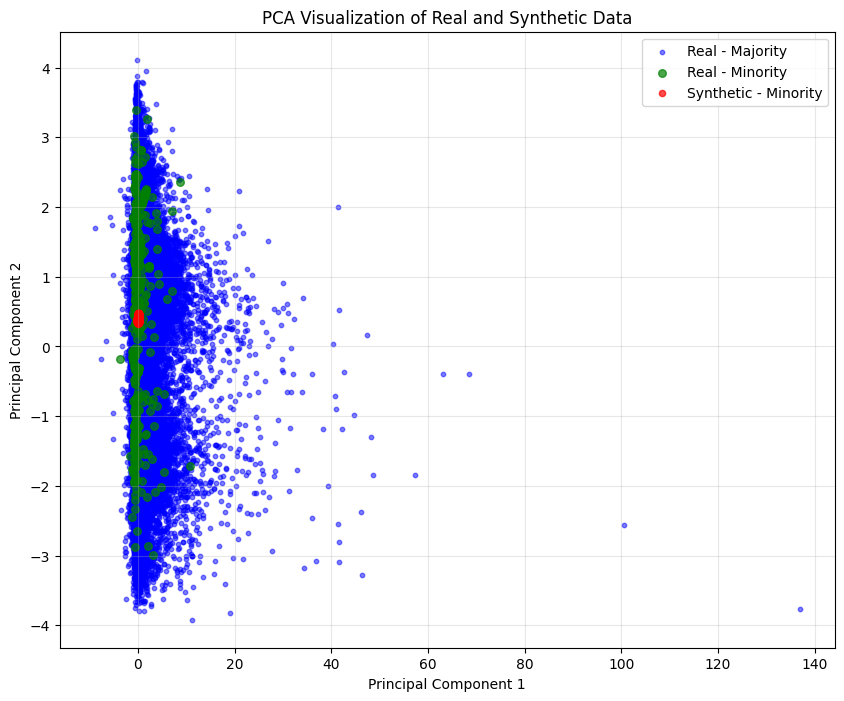


Comparing multiple Random Forest configurations...

Original RF Default:
ROC-AUC: 0.9472
Average Precision: 0.8318
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Original RF with Class Weights:
ROC-AUC: 0.9477
Average Precision: 0.8419
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.71      0.81        98

    accuracy                           1.00     56962
   macro avg       0.97      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Original RF without Bootstrap:
ROC-AUC: 0.9576
Average Precision: 0.8443
Classification Report:
            

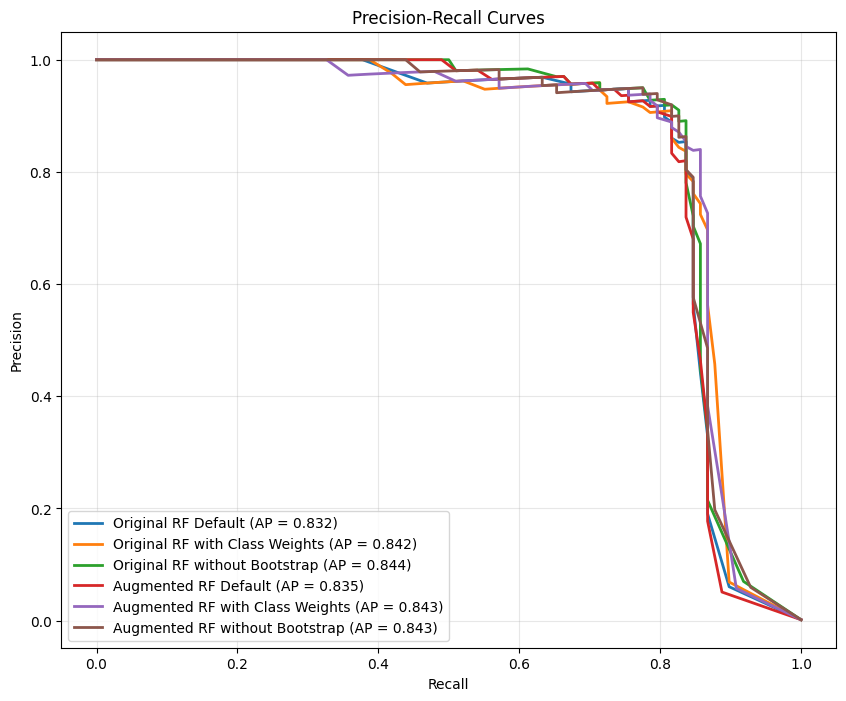

{'vae': <VAE name=vae, built=False>,
 'synthetic_data': array([[2.8235102e-19, 1.9943391e-20, 1.0000000e+00, ..., 5.6035846e-01,
         6.7331624e-04, 2.1665770e-01],
        [5.7591904e-12, 2.7492216e-12, 1.0000000e+00, ..., 5.8218908e-01,
         1.0729194e-02, 4.0994301e-01],
        [9.0520082e-17, 1.2490513e-17, 1.0000000e+00, ..., 6.2004191e-01,
         1.7540575e-03, 2.4006234e-01],
        ...,
        [8.5348438e-12, 2.0343300e-12, 1.0000000e+00, ..., 4.7242421e-01,
         1.5244999e-02, 2.7505028e-01],
        [1.8453923e-07, 4.7953819e-08, 9.9999988e-01, ..., 5.6304026e-01,
         5.7678405e-02, 4.7930750e-01],
        [2.4860636e-10, 8.6452762e-11, 1.0000000e+00, ..., 5.5719310e-01,
         2.3173457e-02, 4.7170541e-01]], dtype=float32),
 'scaler': StandardScaler(),
 'model_results': {'Original RF Default': {'auc': 0.9472177799088122,
   'avg_precision': 0.8318079987704199,
   'config': {'name': 'RF Default', 'bootstrap': True, 'class_weight': None},
   'data': 'Or

In [25]:
run_vae_pipeline(df, 'Class', latent_dim=8, hidden_dims=[128, 64], 
                     epochs=7, batch_size=32, beta=0.5, synthetic_multiplier=10)

## Findings
The model results showcase the performance of various Random Forest (RF) configurations applied to both original and augmented datasets. For the original data, the RF model without bootstrap performed the best, achieving an AUC of 0.957 and an average precision of 0.844. When class weights were applied, the model showed a slight improvement in average precision (0.842) but with a marginal decrease in AUC. On the augmented data, the model without bootstrap again outperformed others, reaching an AUC of 0.962 and an average precision of 0.843. The use of class weights in the augmented dataset improved the average precision slightly (0.843) while maintaining a high AUC (0.952). Overall, the RF model without bootstrap on the augmented dataset provides the best combination of high AUC and precision, indicating that data augmentation effectively supports model performance.